In [28]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import MSELoss
from torch import optim
from tqdm import tqdm, trange
import logging
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader, TensorDataset
from torchvision import datasets, transforms
from datetime import datetime
import json

In [29]:
class DenseNN(nn.Module):
    """
    Fully connected neural network
    """
    def __init__(self, num_hidden_units):
        super(DenseNN, self).__init__()
        self.num_hidden_units = num_hidden_units
        self.l1 = nn.Linear(784, num_hidden_units)
        self.activation_fun = nn.ReLU()
        self.l2 = nn.Linear(num_hidden_units, 10)

    def forward(self, x):
        return self.l2(self.activation_fun(self.l1(x)))
    
    def set_params(self, params : list[torch.Tensor]):
        """
        Set the parameters of the neural network to the given values
        params:
            params: list of Tensors which match the sizes of the current models parameters
        """
        ind = 0
        for p in self.parameters():
            if p.requires_grad:
                if p.shape != params[ind].shape:
                    raise Exception(f"Supplied parameters did not match model parameter shapes: parameter group {ind} had shape {params[0].shape} but expected shape {p.shape}")
                p.data = params[ind].data
                ind += 1

    def get_params(self) -> list[torch.Tensor]:
        """
        Return a list of the current model parameters
        """
        return [p for p in self.parameters() if p.requires_grad]
    
def train(model : DenseNN,
          train_loader : DataLoader,
          optimizer : torch.optim.SGD,
          loss_fn : torch.nn.modules.loss._Loss | torch.nn.modules.loss._WeightedLoss,
          args : dict) -> float:
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if not args["pre_transfer"]:
            data, target = data.to(args["device"]), target.to(args["device"])
        model.zero_grad()
        output = model(data)
        loss = loss_fn(output, target) / len(data)
        epoch_loss += loss * len(data)
        loss.backward()
        optimizer.step()
    return epoch_loss.item() / len(train_loader.dataset)

def test(model : DenseNN,
        test_loader : DataLoader,
        loss_fn : torch.nn.modules.loss._Loss | torch.nn.modules.loss._WeightedLoss,
        args : dict) -> float:
    model.eval()
    model.zero_grad(set_to_none=False)
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            if not args["pre_transfer"]:
                data, target = data.to(args["device"]), target.to(args["device"])
            output = model(data)
            test_loss += loss_fn(output, target)
    return test_loss.item() / len(test_loader.dataset)

In [30]:
def cat_and_flatten(input : tuple[torch.Tensor]):
	return torch.cat([torch.flatten(i) for i in input])

def set_seeds(seed : int):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def set_device(args : dict):
    if torch.cuda.is_available():
        args["device"] = torch.device("cuda")
    else:
        args["device"] = torch.device("cpu")
    return args

def get_data(args) -> tuple[DataLoader, DataLoader]:
    """
    Get data loaders for train and test data
    """
    transform=transforms.Compose([
            transforms.ToTensor(),
            torch.flatten
            ])
    data_rng = np.random.RandomState(args["data_seed"])

    dataset1 = datasets.MNIST('./mnist_data', train=True, download=True,
                    transform=transform, target_transform=transforms.Compose([one_hot_transform]))
    dataset2 = datasets.MNIST('./mnist_data', train=False, download=True,
                    transform=transform, target_transform=transforms.Compose([one_hot_transform]))
    dataset1 = Subset(dataset1, data_rng.choice(len(dataset1), args["train_size"], replace=False))
    if not args["pre_transfer"]:
        # For use if not transferring to GPU before training loop
        train_rng = torch.Generator()
        train_rng.manual_seed(args["data_seed"])
        test_rng = torch.Generator()
        train_rng.manual_seed(args["data_seed"] + 1)
        train_loader = DataLoader(dataset1, batch_size=args["batch_size"], shuffle=True, generator=train_rng)
        test_loader = DataLoader(dataset2, batch_size=args["test_batch_size"], generator=test_rng)
    else:
        # Transfer whole datasets to device (i.e. GPU) before training (Faster)
        train_loader, test_loader = load_data_to_device(dataset1, dataset2, args)
    return train_loader, test_loader

def one_hot_transform(y):
        """
        Transform to convert class labels to one-hot representation
        params:
            y: [list : int]
        return (tensor, n x num_classes)
        """
        return torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)

def load_data_to_device(train_dataset, test_dataset, args):
    """
    Given a suitably sized dataset, transfer to device before training and return related DataLoader objects.
    As MNIST is small, saves data transfer on every train/test iteration.
    params:
        train_dataset:
        test_dataset:
        args
    return: (DataLoader, Dataloader)
    """
    train_rng = torch.Generator()
    train_rng.manual_seed(args["data_seed"])
    test_rng = torch.Generator()
    train_rng.manual_seed(args["data_seed"] + 1)

    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
    _, (images, labels) = next(enumerate(train_loader))
    images, labels = images.to(args["device"]), labels.to(args["device"])
    train_loader = DataLoader(TensorDataset(images, labels), batch_size=args["batch_size"], shuffle=True, generator=train_rng)
    
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
    _, (images, labels) = next(enumerate(test_loader))
    images, labels = images.to(args["device"]), labels.to(args["device"])
    test_loader = DataLoader(TensorDataset(images, labels), batch_size=args["test_batch_size"], shuffle=True, generator=test_rng)
    return train_loader, test_loader

def setup_log_path(datetime : str) -> str:
    os.makedirs(f"./log/{datetime}/", exist_ok = True)
    return f"./log/{datetime}/"

def setup_log(path : str) -> None:
    logging.basicConfig(filename=path,
                            filemode='a',
                            format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                            datefmt='%H:%M:%S',
                            level=logging.DEBUG,
                            force=True)
    
def get_datetime_str() -> str:
    date_now = str(datetime.now().date())
    time_now = str(datetime.now().time())[:-7].replace(":", ";")
    return f"{date_now}_{time_now}"

def save_model(model, path : str) -> None:
    torch.save(model.state_dict(), path)

def save_json(obj, path : str) -> None:
    with open(path, "w") as outfile:
        outfile.write(json.dumps(obj, indent=4))

def load_model(num_hidden_units, path : str):
    model = DenseNN(num_hidden_units)
    model.load_state_dict(torch.load(path))
    return model

def load_json(path : str) -> dict:
    with open(path, "r") as infile:
        return json.load(infile)
    
def extend_params(params : list[torch.Tensor],
                  new_model_size : int,
                  device : torch.device) -> list[torch.Tensor]:
    """Extend parameters to shape of larger model, new parameters are set to 0."""
    hidden_unit_diff = new_model_size - params[0].size(dim=0)
    params[0] = torch.cat([params[0], torch.normal(0, 0.01, size=(hidden_unit_diff, 784), device=device)], dim=0)
    assert params[0].shape == (new_model_size, 784), f"Expected {(new_model_size, 784)} but got {params[0].shape}"
    params[1] = torch.cat([params[1], torch.normal(0, 0.01, size=(hidden_unit_diff,), device=device)], dim=0)
    assert params[1].shape[0] == (new_model_size), f"Expected {new_model_size} but got {params[1].shape}"
    params[2] = torch.cat([params[2], torch.normal(0, 0.1, size=(10, hidden_unit_diff), device=device)], dim=1)
    assert params[2].shape == (10, new_model_size), f"Expected {(10, new_model_size)} but got {params[2].shape}"
    return params

def sattr(d, *attrs):
    # Adds "val" to dict in the hierarchy mentioned via *attrs
    for attr in attrs[:-2]:
        # If such key is not found or the value is primitive supply an empty dict
        if d.get(attr) is None or not isinstance(d.get(attr), dict):
            d[attr] = {}
        d = d[attr]
    d[attrs[-2]] = attrs[-1]

def setup_exp(args) -> tuple[dict, dict, str, DataLoader, DataLoader]:
    """Set state of rng's, setup logging, get device, and get data.
    return: experiment_log, args, log_path, train_loader, test_loader
    """
    experiment_log = {"args": args}
    set_seeds(args["seed"])
    args = set_device(args)
    exp_datetime = get_datetime_str()
    log_path = setup_log_path(exp_datetime)
    setup_log(f"{log_path + 'training.log'}")
    train_loader, test_loader = get_data(args)
    return experiment_log, args, log_path, train_loader, test_loader

In [31]:
def get_weight_update(model : DenseNN,
                      train_loader : DataLoader,
                      optimizer : torch.optim.SGD,
                      loss_fn : torch.nn.modules.loss._Loss | torch.nn.modules.loss._WeightedLoss,
                      args : dict) -> tuple[torch.Tensor, float]:
    """Get the weight update direction (full batch gradient descent) without updating the model parameters.

    Also returns the training loss for the epoch.
    return: weight update (torch.Tensor), epoch train loss (float)
    """
    model.train()
    model.zero_grad()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if not args["pre_transfer"]:
            data, target = data.to(args["device"]), target.to(args["device"])
        output = model(data)
        loss = loss_fn(output, target) / len(data)
        epoch_loss += loss * len(data)
        loss.backward()
    return (-optimizer.param_groups[0]['lr'] * cat_and_flatten([p.grad for p in model.parameters()])).clone(), epoch_loss.item()

def get_landscape_metrics(model : DenseNN,
                          normalised_weight_update : torch.Tensor,
                          test_loader : DataLoader,
                          optimizer : torch.optim.SGD,
                          loss_fn : torch.nn.modules.loss._Loss | torch.nn.modules.loss._WeightedLoss,
                          args : dict) -> tuple[torch.Tensor, float]:
    """Get test landscape metrics relating to slope and curvature
    
    Where v is the normalised_weight_update and <.,.> is the dot product:
    return: jacobian norm, <jacobian,v>, <v,Hv>, test loss
    """
    model.eval()
    model.zero_grad(set_to_none=False)
    test_loss = 0
    for data, target in test_loader:
        if not args["pre_transfer"]:
            data, target = data.to(args["device"]), target.to(args["device"])
        output = model(data)
        test_loss += loss_fn(output, target)
    # Compute gradient of loss function wrt model parameters (J)
    jacobian = torch.autograd.grad(test_loss / len(test_loader.dataset), model.get_params(), create_graph=True)
    j_norm = torch.linalg.norm(torch.cat([i.view(-1) for i in jacobian])).item()
    normalised_jacobian = nn.functional.normalize(torch.cat([i.view(-1) for i in jacobian]), dim=0)
    jv_product = torch.dot(normalised_jacobian, normalised_weight_update).item()
    hv_product = torch.autograd.grad(torch.cat([i.view(-1) for i in jacobian]), model.get_params(), grad_outputs=normalised_weight_update, retain_graph=True)
    vhv_product = torch.dot(normalised_weight_update, cat_and_flatten(hv_product)).item()
    return j_norm, jv_product, vhv_product, test_loss.item() / len(test_loader.dataset)

def update_model_parameters(model : DenseNN,
                            weight_update : torch.Tensor) -> None:
    with torch.no_grad():
        model_params = nn.utils.parameters_to_vector(model.parameters())
        model_params += weight_update
        nn.utils.vector_to_parameters(model_params, model.parameters())

def train_and_get_metrics(model : DenseNN,
        train_loader : DataLoader,
        test_loader : DataLoader,
        optimizer : torch.optim.SGD,
        loss_fn : torch.nn.modules.loss._Loss | torch.nn.modules.loss._WeightedLoss,
        args : dict,
        log_path : str,
        record_metrics : bool,
        end_condition : int) -> dict:
    """Run full batch gradient descent, taking landscape metrics at every epoch
    params:
        end_condition: (int) 0: End after record count reaches limit,
                             1: End after train loss reaches steady state,
                             2: End after train and test loss reach steady state
    return: dict with keys {"train_losses", 
                            "test_losses",
                            "train_steady_state_start",
                            "test_steady_state_start",
                            "jv_products",
                            "vhv_products",
                            "j_norms",
                            "weight_update_norms"}
    """
    train_losses = []
    test_losses = []
    jv_products = []
    vhv_products = []
    j_norms = []
    weight_update_norms = []
    train_steady_state_epoch = 0
    test_steady_state_epoch = 0
    steady_state_record_count = 0
    save_model(model, f"{log_path + 'model_size_' + str(model.num_hidden_units)}_initial.pt")
    with trange(args["epochs"]) as pbar:
        for epoch in pbar:
            # Get weight update direction using the full batch of training data
            weight_update, epoch_loss = get_weight_update(model, train_loader, optimizer, loss_fn, args)
            train_losses.append(epoch_loss / len(train_loader.dataset))
            if record_metrics:
                if train_steady_state_epoch != 0:
                    steady_state_record_count += 1
                weight_update_norms.append(torch.linalg.norm(weight_update).item())
                normalised_weight_update = nn.functional.normalize(weight_update, dim=0)
                # Get landscape metrics of test loss function
                j_norm, jv_product, vhv_product, test_loss = get_landscape_metrics(model, normalised_weight_update, test_loader, optimizer, loss_fn, args)
                j_norms.append(j_norm)
                jv_products.append(jv_product)
                vhv_products.append(vhv_product)
            else:
                test_loss = test(model, test_loader, loss_fn, args)
            test_losses.append(test_loss)
            
            update_model_parameters(model, weight_update)
            
            if epoch > 1000:
                if abs(sum(train_losses[-1000:-500])/500 - sum(train_losses[-500:])/500) < sum(train_losses[-1000:-500])/500 * 0.01:
                    train_steady_state_epoch = epoch - 500
                    if end_condition == 1:
                        break
                if abs(sum(test_losses[-1000:-500])/500 - sum(test_losses[-500:])/500) < sum(test_losses[-1000:-500])/250 * 0.01:
                    test_steady_state_epoch = epoch - 500
                if train_steady_state_epoch != 0 and test_steady_state_epoch != 0 and end_condition == 2:
                    break

            if record_metrics and steady_state_record_count == 500 and end_condition == 0:
                break

            logging.info(f"epoch: {epoch}, train: {train_losses[-1]:.16f}, test: {test_losses[-1]:.16f}")
            pbar.set_postfix_str(f"train: {train_losses[-1]}, test: {test_losses[-1]}", refresh=True)
    save_model(model, f"{log_path + 'model_size_' + str(model.num_hidden_units)}_{epoch}_epochs.pt")
    output = {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_steady_state_start": train_steady_state_epoch,
        "test_steady_state_start": test_steady_state_epoch,
        "jv_products": jv_products,
        "vhv_products": vhv_products,
        "j_norms": j_norms,
        "weight_update_norms": weight_update_norms
    }
    return output

In [35]:
def get_number_of_parameters(num_hidden_units):
	"""
	Number of parameters in the network for MNIST (dimension = 784, number of classes = 10),
	get the number of parameters in a model with num_hidden_units number of hidden units.
	params:
		num_hidden_units: (int)
	return (int)
	"""
	return (784 + 1) * num_hidden_units + (num_hidden_units + 1) * 10

In [75]:
# test0 = load_json("./log/weight_convergence_tests/2023-08-15_10;14;31/experiment_log.json")["model_20"]
# test1 = load_json("./log/weight_convergence_tests/2023-08-15_10;15;38/experiment_log.json")["model_40"]
# test2 = load_json("./log/weight_convergence_tests/2023-08-15_10;47;05/experiment_log.json")["model_60"]
test3 = load_json("./log/weight_convergence_tests/2023-08-15_10;47;58/experiment_log.json")["model_80"]
test4 = load_json("./log/weight_convergence_tests/2023-08-15_11;04;29/experiment_log.json")["model_100"]

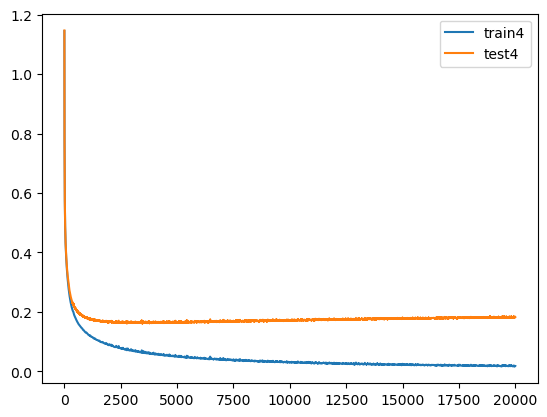

In [140]:
# plt.plot(test0["train_losses"], label="train0")
# plt.plot(test0["test_losses"], label="test0")
# plt.plot(test1["train_losses"], label="train1")
# plt.plot(test1["test_losses"], label="test1")
# plt.plot(test2["train_losses"], label="train2")
# plt.plot(test2["test_losses"], label="test2")
# plt.plot(test3["train_losses"], label="train3")
# plt.plot(test3["test_losses"], label="test3")
plt.plot(test4["train_losses"], label="train4")
plt.plot(test4["test_losses"], label="test4")
plt.legend()

Text(0, 0.5, 'Mean absolute change in weights')

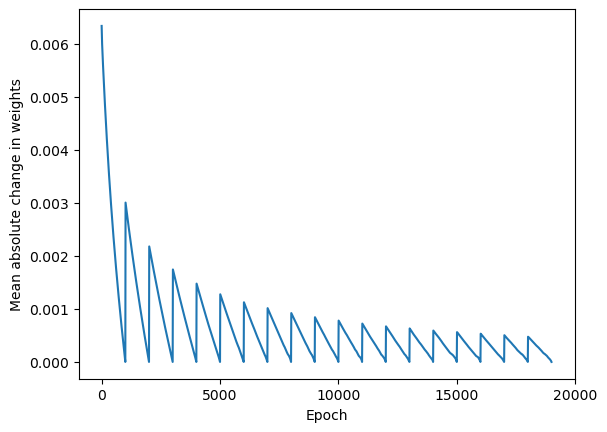

In [143]:
# plt.plot(np.array(test0["weight_diffs"])) #* get_number_of_parameters(20))
# plt.plot(np.array(test1["weight_diffs"])) #* get_number_of_parameters(40))
# plt.plot(np.array(test2["weight_diffs"])) #* get_number_of_parameters(60))
# plt.plot(np.array(test3["weight_diffs"])) #* get_number_of_parameters(40))
plt.plot(np.array(test4["weight_diffs"]))#* get_number_of_parameters(100))
plt.xticks(np.arange(0,2500,500), [0,5000,10000,15000,20000])
plt.xlabel("Epoch")
plt.ylabel("Mean absolute change in weights")

In [113]:
weights1 = [0 for i in range(20)]
for path, dirs, files in os.walk("./log/weight_convergence_tests/2023-08-15_10;47;58/"):
    for file in files:
        if "epochs" in file:
            index = int(file.split("_")[-2]) // 1000
            weights1[index] = cat_and_flatten(load_model(80,"/".join([path, file])).get_params())

weights2 = [0 for i in range(20)]
for path, dirs, files in os.walk("./log/weight_convergence_tests/2023-08-15_11;04;29/"):
    for file in files:
        if "epochs" in file:
            index = int(file.split("_")[-2]) // 1000
            weights2[index] = cat_and_flatten(load_model(100,"/".join([path, file])).get_params())

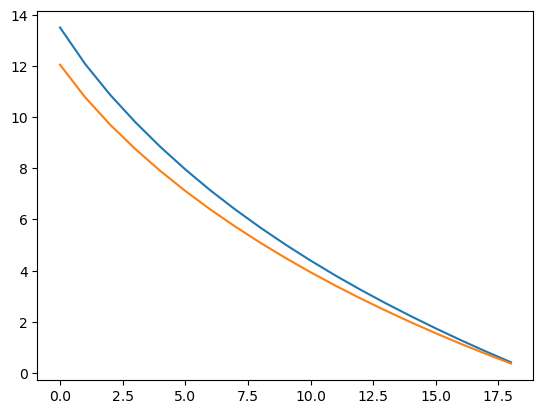

In [119]:
plt.plot([torch.sum(torch.abs(weights1[-1] - i)).item() / 80 for i in weights1[:-1]])
plt.plot([torch.sum(torch.abs(weights2[-1] - i)).item() / 100 for i in weights2][:-1])

In [55]:
weights1= cat_and_flatten(load_model(20, "./log/weight_convergence_tests/2023-08-14_21;43;52/model_size_20_14999_epochs.pt").get_params())
weights2 = cat_and_flatten(load_model(20, "./log/weight_convergence_tests/2023-08-14_21;43;52/model_size_20_19999_epochs.pt").get_params())

In [59]:
torch.square(weights1 - weights2)

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.3329e-05, 4.0438e-04,
        7.7603e-05], grad_fn=<PowBackward0>)

tensor([-0.0073,  0.0182,  0.0050,  ...,  0.0517,  0.2170,  0.1036],
       grad_fn=<CatBackward0>)

In [21]:
args = {
    "seed": 3,
    "data_seed": 2147483647,
    "train_size": 4000,
    "batch_size": 64,
    "test_batch_size": 1000,
    "pre_transfer": True,
    "epochs": 50000,
    "lr": 0.01,
    "momentum": 0.95,
    "gamma": 0.9,
    "loss_fn": "mse",
}

In [16]:
for num_hidden_units in [20]:#[20, 40, 60, 80, 100, 120, 140]:
    experiment_log, args, log_path, train_loader, test_loader = setup_exp(args)
    #start_model = load_model(20, r"./log/testing_13_8/dataseed_2147483647/seed2_start_model/2023-08-13_17;30;29/model_size_20_7587_epochs.pt").to(args["device"])
    model = DenseNN(num_hidden_units).to(args["device"])
    #model.set_params(extend_params(start_model.get_params(), num_hidden_units, args["device"]))
    optimizer = optim.SGD(model.parameters(), lr=args["lr"], momentum=args["momentum"])
    loss_fn = MSELoss(reduction="sum")
    # SET START/END AT STEADY STATE
    experiment_log[f"model_{model.num_hidden_units}"] = train_and_get_metrics(model, train_loader, test_loader, optimizer, loss_fn, args, log_path, True, 0)
    args.pop("device")
    save_json(experiment_log, f"{log_path + 'experiment_log'}.json")

  1%|          | 289/50000 [00:51<2:28:29,  5.58it/s, train: 0.899452880859375, test: 0.9000134765625]  


KeyboardInterrupt: 

In [22]:
def combine(dict1, dict2):
    for key in dict1.keys():
        if key == "train_steady_state_start" or key == "test_steady_state_start":
            continue
        if len(dict1[key]) > 1000 or len(dict2[key]) > 1000:
            dict1[key] = (np.array(dict1[key][-1000:]) + np.array(dict2[key][-1000:])) / 2
        else:
            dict1[key] = (np.array(dict1[key]) + np.array(dict2[key])) / 2

In [23]:
start_path = ["./log/testing_13_8/dataseed_2147483647/seed2_start_model_1"]
              #"./log/testing_13_8/dataseed_2147483647/seed2_start_model_2",
              #"./log/testing_13_8/dataseed_2147483647/seed2_start_model_3"]
results = {}

for start in start_path:
    for path, dirs, files in os.walk(start):
        # if "start_model" in path:
        #     continue 
        for file in files:
            if "experiment_log" in file:
                exp_log = load_json("/".join([path,file]))
                for key in exp_log.keys():
                    if key.startswith("model_"):
                        num_hidden_units = int(key.split("_")[-1])
                        break
                if f"model_{num_hidden_units}" in results:
                    combine(results[f"model_{num_hidden_units}"], exp_log[f"model_{num_hidden_units}"])
                else:
                    results[f"model_{num_hidden_units}"] = exp_log[f"model_{num_hidden_units}"]


In [24]:
results["model_20"].keys()

dict_keys(['train_losses', 'test_losses', 'train_steady_state_start', 'test_steady_state_start', 'jv_products', 'vhv_products', 'j_norms', 'weight_update_norms'])

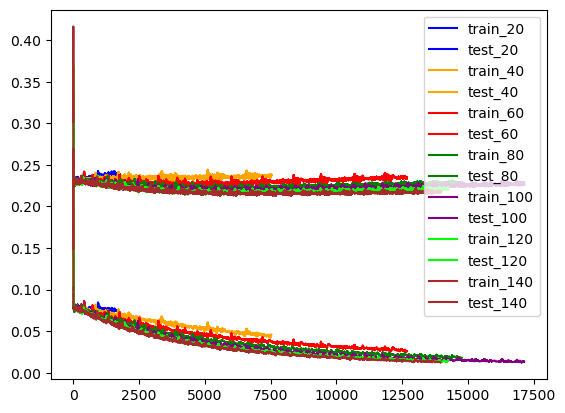

In [27]:
colours = ["blue", "orange", "red", "green", "purple", "lime","brown"]
for i, num in enumerate([20,40,60,80,100,120,140]):
    train_losses, test_losses = results[f"model_{num}"]["train_losses"], results[f"model_{num}"]["test_losses"]
    plt.plot(train_losses, label=f"train_{num}", color=colours[i])
    plt.plot(test_losses, label=f"test_{num}", color=colours[i])
    plt.legend()
# plt.ylim(0,0.3)

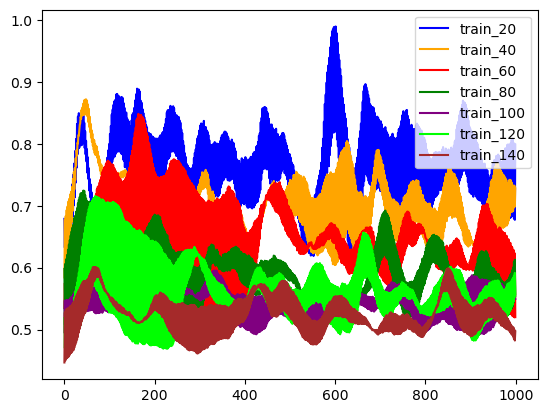

In [15]:
colours = ["blue", "orange", "red", "green", "purple", "lime", "brown"]
for i, num in enumerate([20,40,60,80,100,120,140]):
    j_norms= results[f"model_{num}"]["j_norms"][-1000:]
    plt.plot(j_norms, label=f"train_{num}", color=colours[i])
    plt.legend()

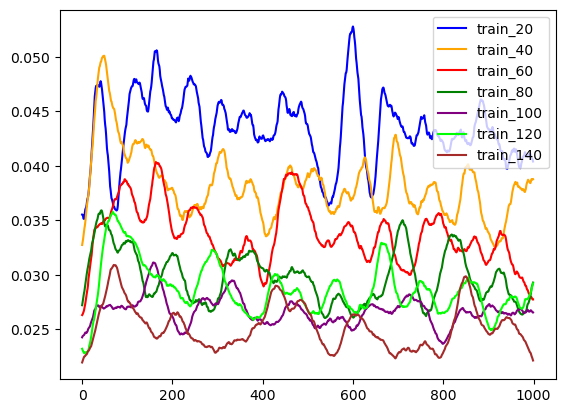

In [16]:
colours = ["blue", "orange", "red", "green", "purple", "lime","brown"]
for i, num in enumerate([20,40,60,80,100,120,140]):
    weight_update_norms = results[f"model_{num}"]["weight_update_norms"][-1000:]
    plt.plot(weight_update_norms, label=f"train_{num}", color=colours[i])
    plt.legend()

In [17]:
update_norms = []
jvs = []
jacob_norms = []
vhvs = []
for i in [20,40,60,80,100,120,140]:
    update_norms.append(np.mean(results[f"model_{i}"]["weight_update_norms"][-1000:]))
    jvs.append(np.mean(results[f"model_{i}"]["jv_products"][-1000:]))
    jacob_norms.append(np.mean(results[f"model_{i}"]["j_norms"][-1000:]))
    vhvs.append(np.mean(results[f"model_{i}"]["vhv_products"][-1000:]))

update_norms_rel = [i / update_norms[0] for i in update_norms]
jacob_norms_rel = [i / jacob_norms[0] for i in jacob_norms]
jvs_rel = [i / jvs[0] for i in jvs]
vhvs_rel = [i / vhvs[0] for i in vhvs]

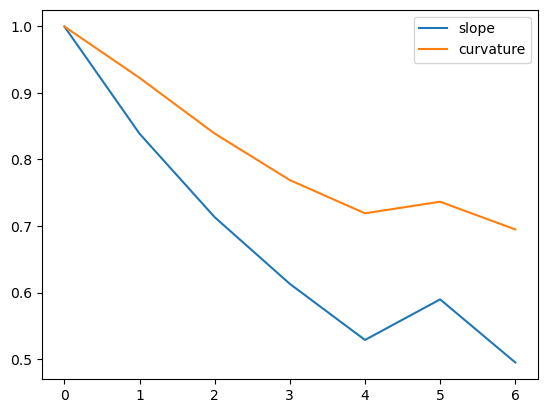

In [18]:
plt.plot(np.multiply(update_norms_rel,jvs_rel), label="slope")
plt.plot(np.multiply(jacob_norms_rel,vhvs_rel), label="curvature")
plt.legend()

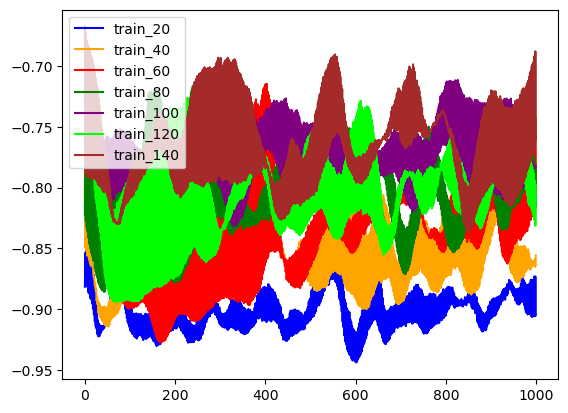

In [19]:
colours = ["blue", "orange", "red", "green", "purple", "lime","brown"]
for i, num in enumerate([20,40,60,80,100,120,140]):
    jv_products = results[f"model_{num}"]["jv_products"][-1000:]
    plt.plot(jv_products, label=f"train_{num}", color=colours[i])
    plt.legend()

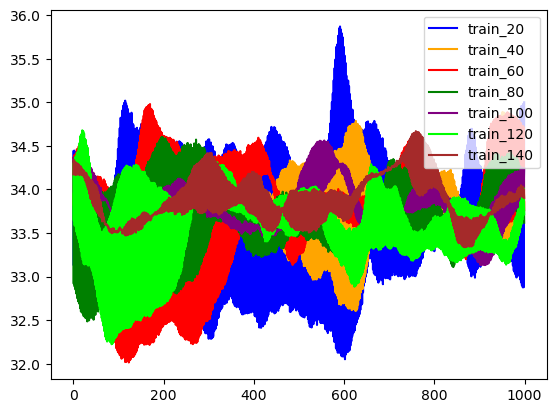

In [21]:
colours = ["blue", "orange", "red", "green", "purple", "lime","brown"]
for i, num in enumerate([20,40,60,80,100,120,140]):
    vhv_products = results[f"model_{num}"]["vhv_products"][-1000:]
    plt.plot(vhv_products, label=f"train_{num}", color=colours[i])
    plt.legend()

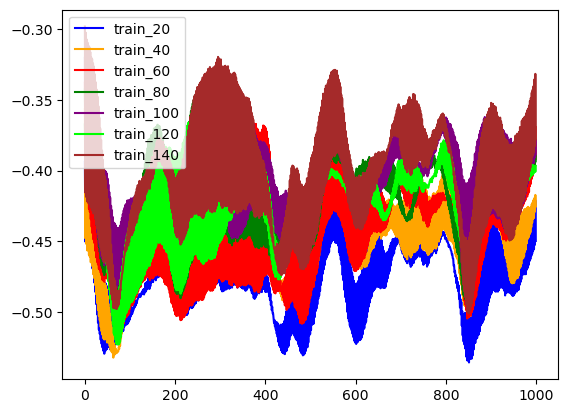

In [22]:
colours = ["blue", "orange", "red", "green", "purple", "lime", "brown"]
for i, num in enumerate([20,40,60,80,100,120,140]):
    jv_products, weight_update_norms = results[f"model_{num}"]["jv_products"][-1000:], results[f"model_{num}"]["weight_update_norms"][-1000:]
    plt.plot(np.multiply(j_norms, jv_products), label=f"train_{num}", color=colours[i])
    plt.legend()

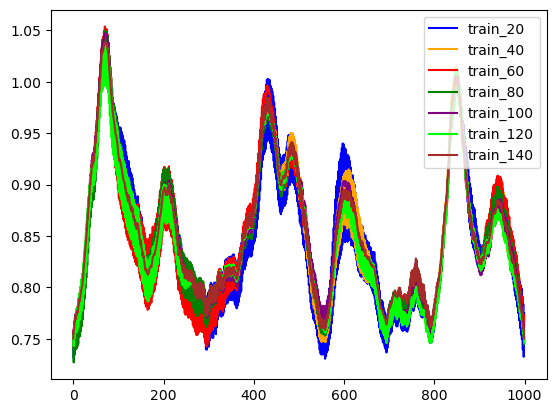

In [23]:
colours = ["blue", "orange", "red", "green", "purple", "lime", "brown"]
for i, num in enumerate([20,40,60,80,100,120,140]):
    vhv_products, j_norms = results[f"model_{num}"]["vhv_products"][-1000:], results[f"model_{num}"]["j_norms"][-1000:]
    plt.plot(np.multiply(weight_update_norms, vhv_products), label=f"train_{num}", color=colours[i])
    plt.legend()

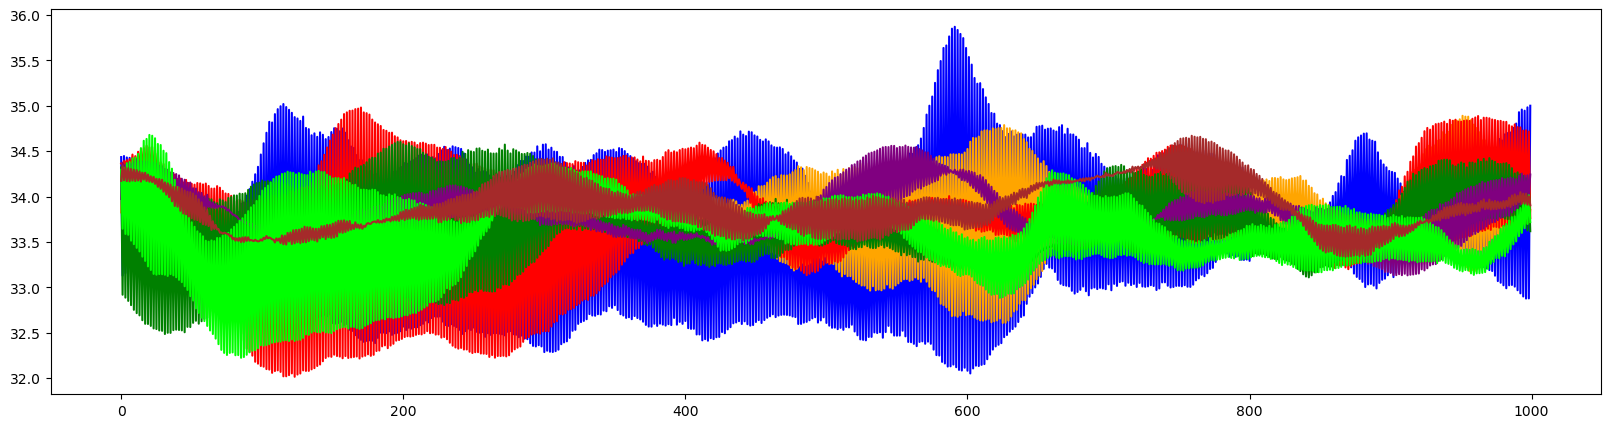

In [26]:
colours = ["blue", "orange", "red", "green", "purple", "lime", "brown"]
fig = plt.figure(figsize=(20,5))
for i, num in enumerate([20,40,60,80,100,120,140]):
    vhv_products, weight_update_norms = results[f"model_{num}"]["vhv_products"][-1000:], results[f"model_{num}"]["weight_update_norms"][-1000:]
    jv_products, j_norms = results[f"model_{num}"]["jv_products"][-1000:], results[f"model_{num}"]["j_norms"][-1000:]
    plt.plot(vhv_products, label=f"train_{num}", color=colours[i])
    # plt.plot(jv_products, label=f"train_{num}", color=colours[i])
    #plt.legend()

0.04126546355520264
0.04277479829154838
0.03630509650949719


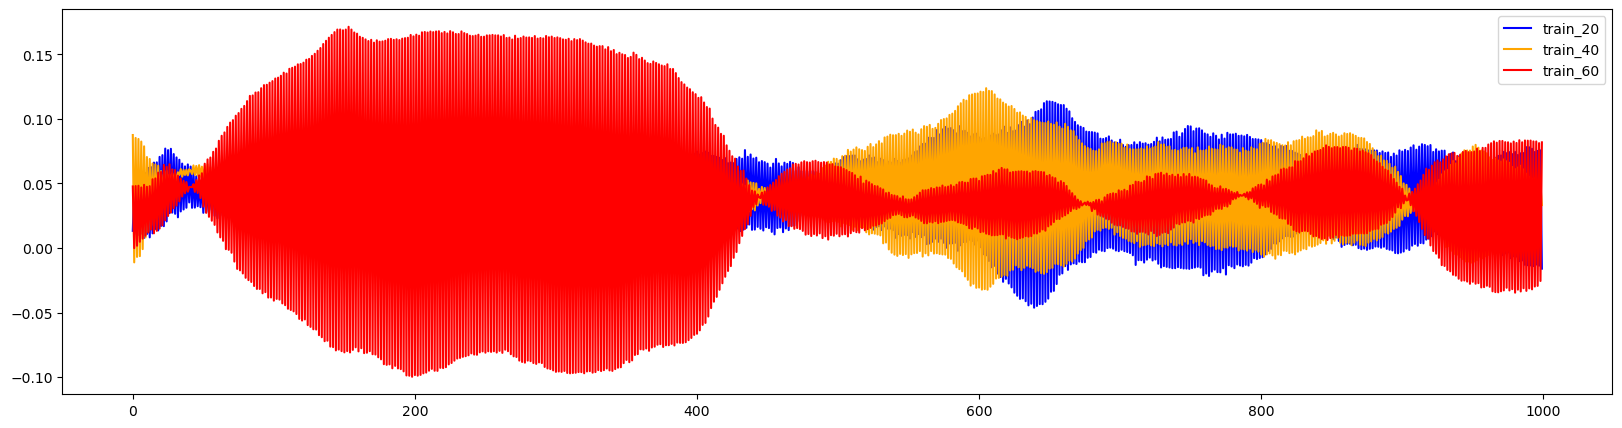

In [31]:
colours = ["blue", "orange", "red", "green", "purple", "lime", "brown"]
fig = plt.figure(figsize=(20,5))
for i, num in enumerate([20,40,60]):
    vhv_products, weight_update_norms = results[f"model_{num}"]["vhv_products"][-1000:], results[f"model_{num}"]["weight_update_norms"][-1000:]
    jv_products, j_norms = results[f"model_{num}"]["jv_products"][-1000:], results[f"model_{num}"]["j_norms"][-1000:]
    print(np.mean(np.add(np.multiply(0.5 *weight_update_norms, vhv_products),np.multiply(j_norms, jv_products))))
    plt.plot(np.add(0.5 * np.multiply(weight_update_norms, vhv_products),np.multiply(j_norms, jv_products)), label=f"train_{num}", color=colours[i])
    plt.legend()

1000
1000
1000
1000
1000
1000
1000


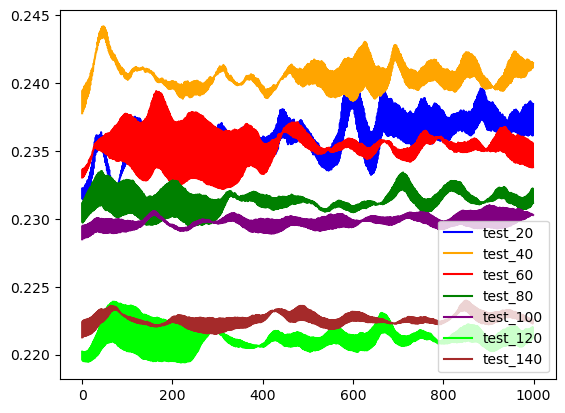

In [30]:
colours = ["blue", "orange", "red", "green", "purple", "lime","brown"]
for i, num in enumerate([20,40,60,80,100,120,140]):
    train_losses, test_losses = results[f"model_{num}"]["train_losses"], results[f"model_{num}"]["test_losses"]
    print(len(train_losses))
    #plt.plot(train_losses, label=f"train_{num}", color=colours[i])
    plt.plot(test_losses, label=f"test_{num}", color=colours[i])
    plt.legend()